# House price prediction 

This is a very convoluted problem with 80 features to determining the SalePrice. <br>
As there are large number of dimentions, determining correct feature vector is a big deal for this data space. <br>
Some of the techniques used in this solution -
 * log, boxcox, standard scaling techniques.
 * Various data transformation and engineering techniques are used. 
 * correlation plots and line graphs are used to identify important features.
 * A suite of machine learning algorithms used to find best algorithm. 
     * xgb, lgb models are used. 

<br>

Submission score (error) with lgbm is 0.1253 (Top 25%)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling 
import math
from pandas.api.types import CategoricalDtype
%matplotlib inline
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [2]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_x = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


In [3]:
test_data=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
print (train_data.shape)
print (test_x.shape)

(1460, 81)
(1459, 80)


In [5]:
train_data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_x = train_data.loc[:,train_data.columns != 'SalePrice']
train_y = train_data.loc[:,train_data.columns == 'SalePrice']
print (train_x.shape)
print (train_y.shape)

(1460, 80)
(1460, 1)


In [7]:
cptry = train_data.loc[:,train_data.columns == 'SalePrice']

In [8]:
train_y.head()

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


In [9]:
# applying log transform to train, test data.
class Utils:
    @classmethod
    def apply_log_trans(cls, indf, collist):
        temp = indf.copy()
        df = pd.DataFrame(np.log(temp[collist]))
        temp = temp.drop(columns=collist)
        outdf = pd.concat([temp,df],join="inner",axis=1)
        return outdf
    
    @classmethod
    def corr_two_feature(cls, indf, f1, f2):
        val = indf[[f1,f2]].corr()[f1][f2]
        return val
    
    @classmethod
    def corr_one_feature(cls, indf, f1):
        train_corr = pd.DataFrame(indf[indf.columns[1:]].corr()[f1][:])
        train_corr =train_corr.sort_values(by=[f1],ascending=False)
        return train_corr
    
    @classmethod
    def corr_similar_features(cls, indf, f1):
        tmp_list = [cols for cols in indf.columns if f1 in cols]
        temp_corr = pd.DataFrame(indf[tmp_list].corr())
        return temp_corr
    
    @classmethod
    def cat_myrename(cls, indf, fture, catlist):
        tmp = indf[fture].astype("category")
        gdict = { val:cnt+1 for cnt,val in enumerate(catlist) }
        tmp = pd.DataFrame(tmp.cat.rename_categories(gdict))
        return tmp
    
    @classmethod
    def missing_vals(cls, indf, id_str=None):
        if (id_str is None):
            id_str = 'Id'
        countdf = indf.count()
        missdict = {}
        for key,val in countdf.items():
            missdict[key] = countdf[id_str] - val
        missdf = pd.DataFrame(missdict.items(),columns=['name','miss_val'])
        miss_pct = pd.DataFrame((missdf['miss_val']/countdf[id_str])*100)
        miss_pct = miss_pct.rename(columns={'miss_val':'miss_pct'})
        missdf = pd.concat([missdf,miss_pct],axis=1,join='inner')
        missdf = missdf.sort_values(by='miss_pct',ascending=False)
        return missdf
    
    @classmethod
    def missing_vals2(cls, indf, id_str=None):
        all_data = indf
        all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
        all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
        missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
        return missing_data
    
    
    @classmethod
    def my_dummies(cls, indf, collist):
        dummy = pd.get_dummies(indf[collist])
        tmp = indf.copy()
        tmp = pd.concat([tmp, dummy],axis=1,join='inner')
        tmp.drop(columns=collist,axis=1,inplace=True)
        return tmp
    
    @classmethod
    def cal_skewness(cls, indf):
        all_data = indf.copy()
        numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
        # Check the skew of all numerical features
        skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        print("\nSkew in numerical features: \n")
        skewness = pd.DataFrame({'Skew' :skewed_feats})
        return skewness

## Understanding of data

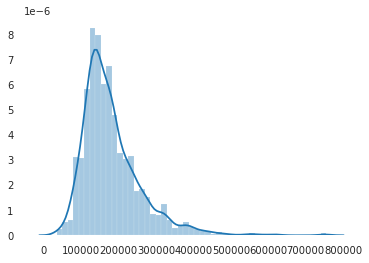

In [10]:
# first understand the target
sns.distplot(train_y)
plt.show()

### target conclusion
* values are too big -> std normalization (or)
* right skew -> log transformation -> also brings the dist as normal


In [11]:
# train_y = Utils.apply_log_trans(train_y, ['SalePrice'])
# train_y

### predictor analysis

As there are a lot of predictors, we need to understand data from top down.<br>
select some best features and format them accordingly. <br>
combine some less useful features in to one. <br>
finally, drop unnessary features.

In [12]:
# # understand feature vectors. First, Profile
# import warnings
# warnings.filterwarnings('ignore')
# profile = pandas_profiling.ProfileReport(train_x)
# profile

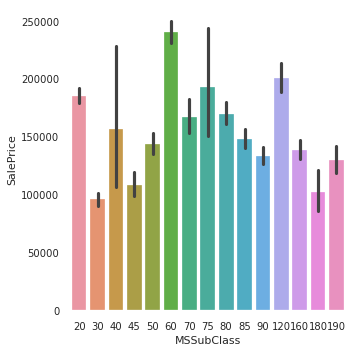

In [13]:
sns.catplot(x="MSSubClass",y="SalePrice",data=train_data, kind="bar")

In [14]:
# train_data_corr = train_data.corr()
# plt.subplots(figsize=(22,9))
# sns.heatmap(train_data_corr,cmap='coolwarm')

In [15]:
# correlation between target and some features.
train_corr = pd.DataFrame(train_data[train_data.columns[1:]].corr()['SalePrice'][:])
train_corr =train_corr.sort_values(by=["SalePrice"],ascending=False)
train_corr

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In **continuous variables**, following are best correlated with saleprice<br>
* OverallQual	0.790982 
* GrLivArea	0.708624
* GarageCars	0.640409
* GarageArea	0.623431
* TotalBsmtSF	0.613581
* 1stFlrSF	0.605852
* FullBath	0.560664
* TotRmsAbvGrd	0.533723
* YearBuilt	0.522897
* YearRemodAdd	0.507101
* GarageYrBlt	0.486362
* MasVnrArea	0.477493
* Fireplaces	0.466929
* EnclosedPorch	-0.128578
* KitchenAbvGr	-0.135907

In [16]:
# N largest correlated features
#saleprice correlation matrix
k = 10 #number of variables for heatmap
# cols = train_data_corr.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(train_data[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [17]:
# tmp_corr = pd.DataFrame(train_data[train_data.columns[1:]].corr()['OverallQual'][:])
# tmp_corr = tmp_corr.sort_values(by=["OverallQual"],ascending=False)
# tmp_corr

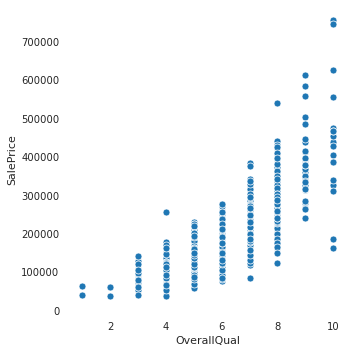

In [18]:
sns.relplot(x="OverallQual",y="SalePrice",data=train_data)

In [19]:
# above correlation is a famous cone graph where relationship is non-linear. it is bad

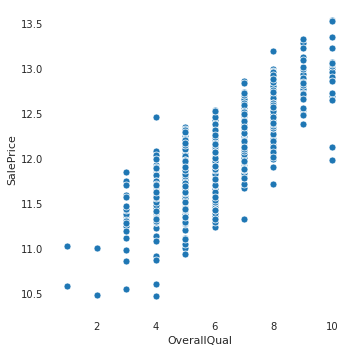

In [20]:
df_y = pd.DataFrame(np.log(train_data['SalePrice']))
new_df = pd.concat([train_data["OverallQual"],df_y],axis=1, join="inner")
sns.relplot(x="OverallQual",y="SalePrice",data=new_df)

In [21]:
# above correlation graph is a linear graph. so, lets apply log trans on target
df = pd.DataFrame(np.log(train_data['SalePrice']))
train_data = train_data.drop(columns=["SalePrice"])
train_data = pd.concat([train_data,df],join="inner",axis=1)
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072541
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254863
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493130
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864462


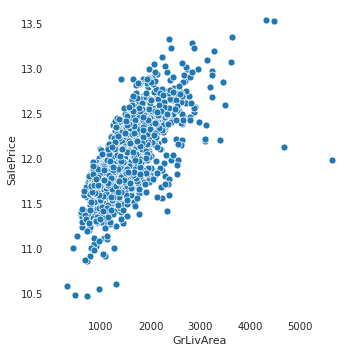

In [22]:
sns.relplot(x="GrLivArea",y="SalePrice",data=train_data)

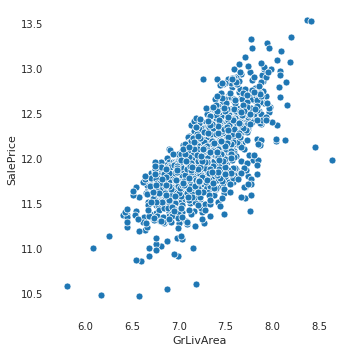

In [23]:
df = pd.DataFrame(np.log(train_data['GrLivArea']))
tmp_df = pd.concat([train_data['SalePrice'],df],join="inner",axis=1)
sns.relplot(x="GrLivArea",y="SalePrice",data=tmp_df)

TODO: lets remove two outliers GrLivArea -> (8.5,12),(8.5,12+)
apply log trans to GrLivArea

In [24]:
collist = ['TotalBsmtSF','GarageArea','GrLivArea']
train_x = Utils.apply_log_trans(train_x,collist)
test_x = Utils.apply_log_trans(test_x,collist)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


# TODO: Highly correlated features
* GrLivArea - TotalRmsAboveGrd (0.82)
* GarageCars - GarageArea (0.88)
* TotalBsmtSF - 1stFlSF  (0.83)
* 

In [25]:
train_x = train_x.drop(columns=["GarageArea","1stFlrSF","TotRmsAbvGrd"])
test_x = test_x.drop(columns=["GarageArea","1stFlrSF","TotRmsAbvGrd"])

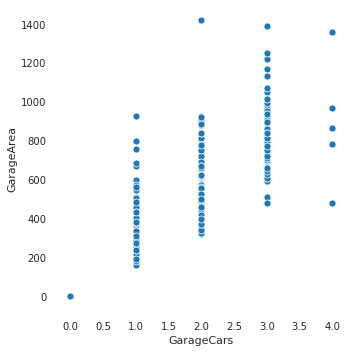

In [26]:
sns.relplot(x="GarageCars",y="GarageArea",data=train_data)

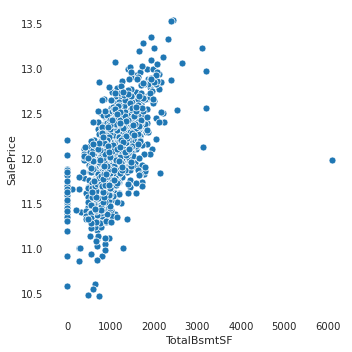

In [27]:

sns.relplot(x="TotalBsmtSF",y="SalePrice",data=train_data)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


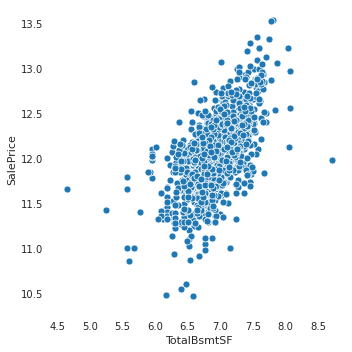

In [28]:
df = pd.DataFrame(np.log(train_data['TotalBsmtSF']))
tmp_df = pd.concat([train_data['SalePrice'],df],join="inner",axis=1)
sns.relplot(x="TotalBsmtSF",y="SalePrice",data=tmp_df)

1. TODO: log trans TotalBsmtSF
2. remove outlier 8.5, 12

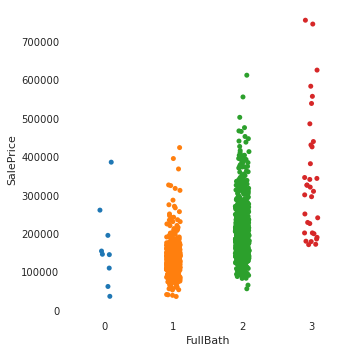

In [29]:
tmp=pd.concat([train_x,train_y],join="inner",axis=1)
sns.catplot(x="FullBath",y="SalePrice",data=tmp)

So, lets keep FullBath as it is.

In [30]:

tmp=pd.concat([train_x,train_y],join="inner",axis=1)
# sns.barplot(x="TotRmsAbvGrd",y="SalePrice",data=tmp)
# sns.catplot(x="TotRmsAbvGrd",y="SalePrice",data=tmp)

In [31]:
# sns.relplot(x="TotRmsAbvGrd",y="SalePrice",data=tmp)

In [32]:
# tmp=pd.concat([train_x,train_y],join="inner",axis=1)
# sns.barplot(x="YearBuilt",y="SalePrice",data=tmp)

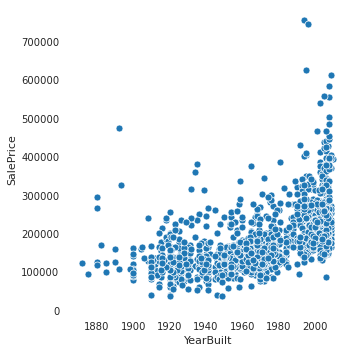

In [33]:
sns.relplot(x="YearBuilt",y="SalePrice",data=tmp)

In [34]:
# train_corr = pd.DataFrame(train_data[train_data.columns[1:]].corr()['SalePrice'][:])
train_x[['YearBuilt','YearRemodAdd']].corr()['YearBuilt']['YearRemodAdd']

0.5928549763436497

In [35]:
train_x.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenP

In [36]:
# sns.relplot(x="GarageYrBlt",y="YearBuilt",data=tmp)
Utils.corr_two_feature(tmp, "GarageYrBlt","YearBuilt")

0.8256674841743434

TODO: drop one of GarageYrBlt, YearBuilt (corr 0.82) [all drops are reference to corr between feature and target]

In [37]:
train_x = train_x.drop(columns=["YearBuilt"])
test_x = test_x.drop(columns=['YearBuilt'])

['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond']
             GarageYrBlt  GarageCars
GarageYrBlt      1.00000     0.58892
GarageCars       0.58892     1.00000


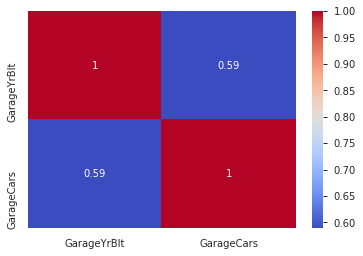

In [38]:
# check correlation between garagexxx features.
desired_cols = [ col for col in tmp.columns if "Garage" in col]
print (desired_cols)
corr_ = Utils.corr_similar_features(tmp, "Garage")
print (corr_)
sns.heatmap(corr_, cmap="coolwarm",annot=True)

<Figure size 1152x432 with 0 Axes>

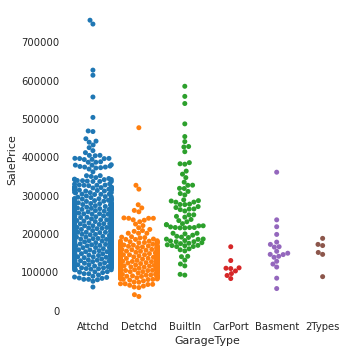

In [39]:
%matplotlib inline
plt.figure(figsize=(16, 6))
sns.catplot(x="GarageType",y="SalePrice",data=tmp,kind="swarm")
plt.show()

TODO: assign numerical values from left to right decreasing

In [40]:

# print (train_x['GarageType'].unique())
# garagelist = ['Attchd', 'BuiltIn','Detchd', 'Basment','CarPort' , '2Types']
# garagelist.reverse()
# # tmp_x = train_x["GarageType"].astype("category",ordered=True,categories=garagelist).cat.codes
# tmp_x = train_x["GarageType"].astype("category")
# cat_type=CategoricalDtype(categories=garagelist,ordered=True)
# tmp_x = tmp_x.astype(cat_type)
# tmp_x.cat.codes

In [41]:
glist = ['Attchd', 'BuiltIn','Detchd', 'Basment','CarPort' , '2Types']
glist.reverse()
tmp = Utils.cat_myrename(train_x, "GarageType", glist)
train_x = train_x.drop(columns=["GarageType"])
train_x = pd.concat([train_x, tmp],join="inner",axis=1)
tmp = Utils.cat_myrename(test_x, "GarageType", glist)
test_x = test_x.drop(columns=["GarageType"])
test_x = pd.concat([test_x, tmp],join="inner",axis=1)

In [42]:
test_x["GarageType"]

0         6
1         6
2         6
3         6
4         6
       ... 
1454    NaN
1455      2
1456      4
1457    NaN
1458      6
Name: GarageType, Length: 1459, dtype: category
Categories (6, int64): [1, 6, 3, 5, 2, 4]

In [43]:
# %matplotlib inline
# plt.figure(figsize=(16, 6))
# sns.catplot(x="GarageFinish",y="SalePrice",data=tmp,kind="swarm")
# plt.show()
train_x["GarageFinish"]

0       RFn
1       RFn
2       RFn
3       Unf
4       RFn
       ... 
1455    RFn
1456    Unf
1457    RFn
1458    Unf
1459    Fin
Name: GarageFinish, Length: 1460, dtype: object

TODO: equal wight to GarageFinish categories. -> replace with ordinal values

In [44]:
gf_order = ['Unf','RFn','Fin']
tmp = Utils.cat_myrename(train_x, "GarageFinish", gf_order)
train_x = train_x.drop(columns=["GarageFinish"])
train_x = pd.concat([train_x, tmp],join="inner",axis=1)
tmp = Utils.cat_myrename(test_x, "GarageFinish", gf_order)
test_x = test_x.drop(columns=["GarageFinish"])
test_x = pd.concat([test_x, tmp],join="inner",axis=1)

In [45]:
#checking the correlation of cars and target
tmp = pd.concat([train_x,train_y],axis=1,join="inner")
val = Utils.corr_two_feature(tmp,"GarageCars","SalePrice")
val

0.640409197258349

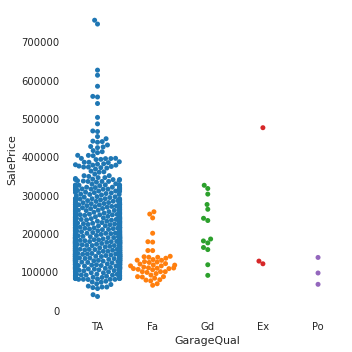

In [46]:
train_x["GarageQual"]
sns.catplot(x="GarageQual",y="SalePrice",data=tmp,kind="swarm")
plt.show()

GarageQual is a rating, so we use ranking here.

In [47]:
qual_order = ['Po','Fa','TA','Gd','Ex']
tmp = Utils.cat_myrename(train_x, "GarageQual", qual_order)
train_x = train_x.drop(columns=["GarageQual"])
train_x = pd.concat([train_x, tmp],join="inner",axis=1)
tmp = Utils.cat_myrename(test_x, "GarageQual", qual_order)
test_x = test_x.drop(columns=["GarageQual"])
test_x = pd.concat([test_x, tmp],join="inner",axis=1)

In [48]:
qual_order = ['Po','Fa','TA','Gd','Ex']
tmp = Utils.cat_myrename(train_x, "GarageCond", qual_order)
train_x = train_x.drop(columns=["GarageCond"])
train_x = pd.concat([train_x, tmp],join="inner",axis=1)
tmp = Utils.cat_myrename(test_x, "GarageCond", qual_order)
test_x = test_x.drop(columns=["GarageCond"])
test_x = pd.concat([test_x, tmp],join="inner",axis=1)

In [49]:
tot_tmp = pd.concat([train_x,train_y],axis=1,join="inner")

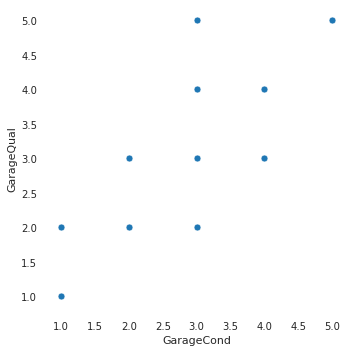

In [50]:
tmp = pd.concat([train_x,train_y],axis=1,join="inner")
sns.relplot(x="GarageCond",y="GarageQual",data=tmp)
# val = Utils.corr_two_feature(tmp,"GarageCond","GarageQual")
# val

drop GarageCond as it correlates too much with GarageQual

In [51]:
train_x.drop(["GarageCond"],axis=1,inplace=True)
test_x.drop(["GarageCond"],axis=1,inplace=True)

-0.09193234263907184


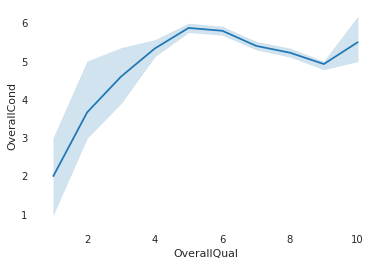

In [52]:
# sns.relplot(x="OverallQual",y="OverallCond",data=tmp)
val = Utils.corr_two_feature(tmp, "OverallQual","OverallCond")
print(val)
sns.lineplot(data=tmp, x="OverallQual",y="OverallCond")

['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF']


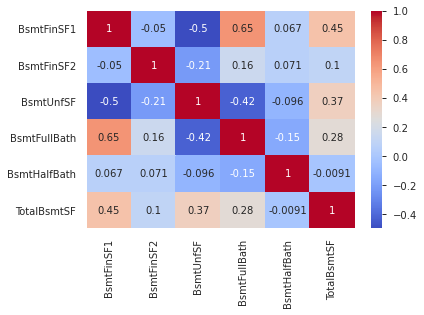

In [53]:
desired_cols = [ col for col in tmp.columns if "Bsmt" in col]
print(desired_cols)
dcorr = train_x[desired_cols].corr()
sns.heatmap(dcorr,cmap="coolwarm",annot=True)

In [54]:
train_x[['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF']].describe()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,BsmtHalfBath,TotalBsmtSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,443.639726,46.549315,567.240411,0.425342,0.057534,-inf
std,456.098091,161.319273,441.866955,0.518911,0.238753,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,-inf
25%,0.000000,0.000000,223.000000,0.000000,0.000000,6.679285
50%,383.500000,0.000000,477.500000,0.000000,0.000000,6.899219
75%,712.250000,0.000000,808.000000,1.000000,0.000000,7.168772
max,5644.000000,1474.000000,2336.000000,3.000000,2.000000,8.717682


In [55]:
train_x = Utils.apply_log_trans(train_x,['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF'])
test_x = Utils.apply_log_trans(test_x,['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [56]:
train_x[['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF']].describe()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,BsmtHalfBath,TotalBsmtSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,-inf,-inf,-inf,0.425342,0.057534,-inf
std,NaN,NaN,NaN,0.518911,0.238753,NaN
min,-inf,-inf,-inf,0.000000,0.000000,-inf
25%,-inf,-inf,5.407172,0.000000,0.000000,6.679285
50%,5.949339,-inf,6.168559,0.000000,0.000000,6.899219
75%,6.568429,-inf,6.694562,1.000000,0.000000,7.168772
max,8.638348,7.295735,7.756195,3.000000,2.000000,8.717682


In [57]:
adf = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',]
train_x[adf]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf
...,...,...,...,...,...
1455,Gd,TA,No,Unf,Unf
1456,Gd,TA,No,ALQ,Rec
1457,TA,Gd,No,GLQ,Unf
1458,TA,TA,Mn,GLQ,Rec


So, lets convert them to a rankings.

In [58]:
train_x['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [59]:
# edit 1: 
# we could map as follows. No need to use cat_myrename func
# qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
# all_df["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)

qual_order = ['Po','Fa','TA','Gd','Ex']
colname = "BsmtQual"
tmp = Utils.cat_myrename(train_x, colname, qual_order)
train_x = train_x.drop(columns=[colname])
train_x = pd.concat([train_x, tmp],join="inner",axis=1)
tmp = Utils.cat_myrename(test_x, colname, qual_order)
test_x = test_x.drop(columns=[colname])
test_x = pd.concat([test_x, tmp],join="inner",axis=1)

qual_order = ['Po','Fa','TA','Gd','Ex']
colname = "BsmtCond"
tmp = Utils.cat_myrename(train_x, colname, qual_order)
train_x = train_x.drop(columns=[colname])
train_x = pd.concat([train_x, tmp],join="inner",axis=1)
tmp = Utils.cat_myrename(test_x, colname, qual_order)
test_x = test_x.drop(columns=[colname])
test_x = pd.concat([test_x, tmp],join="inner",axis=1)

qual_order = ['No','Mn','Av','Gd']
colname = "BsmtExposure"
tmp = Utils.cat_myrename(train_x, colname, qual_order)
train_x = train_x.drop(columns=[colname])
train_x = pd.concat([train_x, tmp],join="inner",axis=1)
tmp = Utils.cat_myrename(test_x, colname, qual_order)
test_x = test_x.drop(columns=[colname])
test_x = pd.concat([test_x, tmp],join="inner",axis=1)


qual_order = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf']
qual_order.reverse()
colname = "BsmtFinType1"
tmp = Utils.cat_myrename(train_x, colname, qual_order)
train_x = train_x.drop(columns=[colname])
train_x = pd.concat([train_x, tmp],join="inner",axis=1)
tmp = Utils.cat_myrename(test_x, colname, qual_order)
test_x = test_x.drop(columns=[colname])
test_x = pd.concat([test_x, tmp],join="inner",axis=1)

colname = "BsmtFinType2"
tmp = Utils.cat_myrename(train_x, colname, qual_order)
train_x = train_x.drop(columns=[colname])
train_x = pd.concat([train_x, tmp],join="inner",axis=1)
tmp = Utils.cat_myrename(test_x, colname, qual_order)
test_x = test_x.drop(columns=[colname])
test_x = pd.concat([test_x, tmp],join="inner",axis=1)

In [60]:
adf = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',]
train_x[adf]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,4,3,1,6,1
1,4,3,4,5,1
2,4,3,2,6,1
3,3,4,1,5,1
4,4,3,3,6,1
...,...,...,...,...,...
1455,4,3,1,1,1
1456,4,3,1,5,3
1457,3,4,1,6,1
1458,3,3,2,6,3


In [61]:
# first get all the categorical features.
all_cols = train_x.columns
num_cols = train_x._get_numeric_data().columns
print (list(set(all_cols)-set(num_cols)))

['BldgType', 'FireplaceQu', 'SaleType', 'MasVnrType', 'Utilities', 'SaleCondition', 'GarageQual', 'MiscFeature', 'BsmtFinType1', 'Electrical', 'GarageType', 'ExterQual', 'BsmtExposure', 'LotShape', 'PavedDrive', 'RoofStyle', 'HouseStyle', 'Heating', 'ExterCond', 'PoolQC', 'BsmtCond', 'Neighborhood', 'RoofMatl', 'LotConfig', 'HeatingQC', 'KitchenQual', 'Condition1', 'BsmtFinType2', 'Functional', 'BsmtQual', 'Street', 'Foundation', 'MSZoning', 'LandSlope', 'Exterior2nd', 'CentralAir', 'Fence', 'Exterior1st', 'Condition2', 'GarageFinish', 'Alley', 'LandContour']


In [62]:
ln = len(list(set(all_cols)-set(num_cols)))
ln

42

In [63]:
outdf = Utils.missing_vals(train_x,'Id')
outdf.head(8)

,name,miss_val,miss_pct
54,PoolQC,1453,99.520548
56,MiscFeature,1406,96.301370
6,Alley,1369,93.767123
55,Fence,1179,80.753425
44,FireplaceQu,690,47.260274
3,LotFrontage,259,17.739726
64,GarageType,81,5.547945
45,GarageYrBlt,81,5.547945


In [64]:
outdf = Utils.missing_vals(test_x,'Id')
outdf.head(8)

,name,miss_val,miss_pct
54,PoolQC,1456,99.794380
56,MiscFeature,1408,96.504455
6,Alley,1352,92.666210
55,Fence,1169,80.123372
44,FireplaceQu,730,50.034270
3,LotFrontage,227,15.558602
45,GarageYrBlt,78,5.346127
66,GarageQual,78,5.346127


Both in train,test data 5 columns lost most of the data. so, lets drop them.
* PoolQC
* MiscFeature
* Alley
* Fence
* FireplaceQu

In [65]:
train_x.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)
test_x.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)

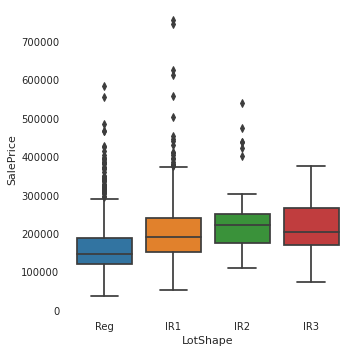

In [66]:
# lets convert all the categorical vectors to numerical
sns.catplot(x='LotShape',y='SalePrice',data=tot_tmp,kind='box')

In [67]:
# get dummies for LotShape
train_x = Utils.my_dummies(train_x, ["LotShape"])
test_x = Utils.my_dummies(test_x, ["LotShape"])

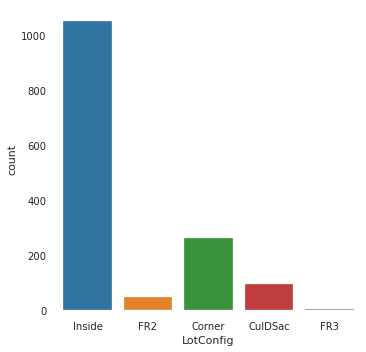

In [68]:
sns.catplot(x="LotConfig",data=train_x,kind="count")

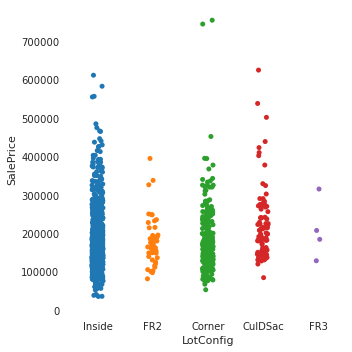

In [69]:
sns.catplot(x="LotConfig",y='SalePrice',data=tot_tmp)

In [70]:
# get dummies for LotShape
train_x = Utils.my_dummies(train_x, ["LotConfig"])
test_x = Utils.my_dummies(test_x, ["LotConfig"])

In [71]:
# and get dummies for all other categorical vectors
catvec = ['Condition1', 'CentralAir', 'ExterQual', 'Foundation', 'Electrical', 'GarageFinish', 'Street', 'BldgType', 'RoofStyle', 'LandSlope', 'BsmtExposure', 'KitchenQual', 'Utilities', 'RoofMatl', 'SaleCondition', 'MSZoning', 'GarageType', 'BsmtFinType2', 'Exterior2nd', 'BsmtCond', 'BsmtQual', 'Functional', 'SaleType', 'HouseStyle', 'Exterior1st', 'HeatingQC', 'Neighborhood', 'Condition2', 'ExterCond', 'MasVnrType', 'PavedDrive', 'BsmtFinType1', 'LandContour', 'GarageQual', 'Heating']
train_x = Utils.my_dummies(train_x,catvec)
test_x = Utils.my_dummies(test_x,catvec)

In [72]:
num_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearRemodAdd', 'MasVnrArea', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'TotalBsmtSF', 'GrLivArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF'],
      dtype='object')

In [73]:
val = Utils.corr_one_feature(tot_tmp,"MSSubClass")
val

,MSSubClass
MSSubClass,1.000000
2ndFlrSF,0.307886
KitchenAbvGr,0.281721
HalfBath,0.177354
FullBath,0.131608
GarageYrBlt,0.085072
GrLivArea,0.081717
LowQualFinSF,0.046474
YearRemodAdd,0.040581
OverallQual,0.032628


No corr and also it is not that beneficial to do onehot of MSSubClass

In [74]:
train_x.drop(['MSSubClass'],axis=1,inplace=True)
test_x.drop(['MSSubClass'],axis=1,inplace=True)

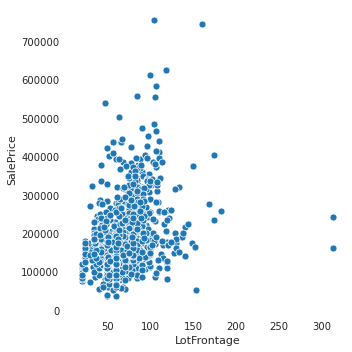

In [75]:
sns.relplot(x="LotFrontage",y="SalePrice",data=tot_tmp)

In [76]:
# correlation between big and small values. so, lets apply log transform to lotfrontage
train_x = Utils.apply_log_trans(train_x,['LotFrontage'])
test_x = Utils.apply_log_trans(test_x,['LotFrontage'])

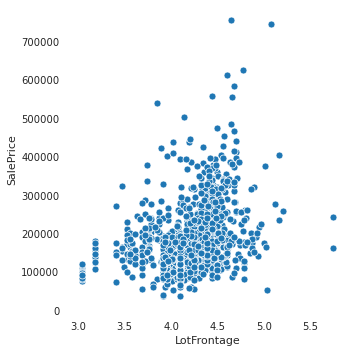

In [77]:
tot_tmp = pd.concat([train_x,train_y],axis=1,join="inner")
sns.relplot(x="LotFrontage",y="SalePrice",data=tot_tmp)

In [78]:
# remove the outliers i.e LotFrontage>5.5
train_x.drop(train_x[train_x['LotFrontage']>5.5].index,inplace=True)

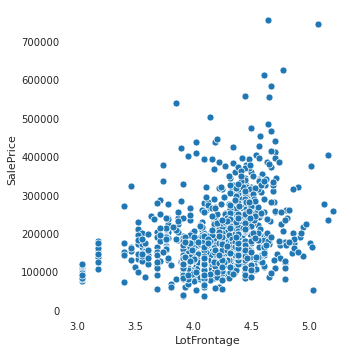

In [79]:
tot_tmp = pd.concat([train_x,train_y],axis=1,join="inner")
sns.relplot(x="LotFrontage",y="SalePrice",data=tot_tmp)

In [80]:
train_x[['LotArea','OverallQual','OverallCond', 'YearRemodAdd', 'MasVnrArea', '2ndFlrSF', 'LowQualFinSF']]
# drop LowQualFinSF as 98% are zeros
# retaining OverallQuall, OverallCond as it is and applying log transformation on LotArea, MasVnrArea, 2ndFlrSF


,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,2ndFlrSF,LowQualFinSF
0,8450,7,5,2003,196.0,854,0
1,9600,6,8,1976,0.0,0,0
2,11250,7,5,2002,162.0,866,0
3,9550,7,5,1970,0.0,756,0
4,14260,8,5,2000,350.0,1053,0
...,...,...,...,...,...,...,...
1455,7917,6,5,2000,0.0,694,0
1456,13175,6,6,1988,119.0,0,0
1457,9042,7,9,2006,0.0,1152,0
1458,9717,5,6,1996,0.0,0,0


In [81]:
train_x = Utils.apply_log_trans(train_x, ['LotArea','MasVnrArea','2ndFlrSF'])
test_x = Utils.apply_log_trans(test_x, ['LotArea','MasVnrArea','2ndFlrSF'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


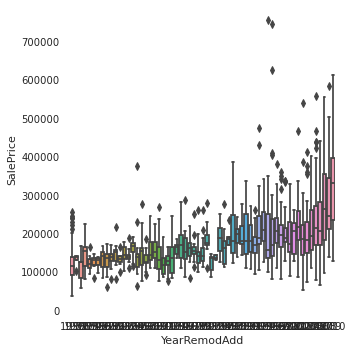

In [82]:
tmp=pd.concat([train_x,train_y],join="inner",axis=1)
sns.catplot(x="YearRemodAdd",y="SalePrice",data=tmp,kind="box")

TODO: YearRemodAdd -> how to transform this?

In [83]:
train_x[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr','KitchenAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF']]

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF
0,1,0,2,1,3,1,0,2003.0,2,0
1,0,1,2,0,3,1,1,1976.0,2,298
2,1,0,2,1,3,1,1,2001.0,2,0
3,1,0,1,0,3,1,1,1998.0,3,0
4,1,0,2,1,4,1,1,2000.0,3,192
...,...,...,...,...,...,...,...,...,...,...
1455,0,0,2,1,3,1,1,1999.0,2,0
1456,1,0,2,0,3,1,2,1978.0,2,349
1457,0,0,2,0,4,1,2,1941.0,1,0
1458,1,0,1,0,2,1,0,1950.0,1,366


TODO: lets add all the bathrooms in to one column and **check that column's importance using random forests at the end.**

In [84]:
tmp = train_x.copy()
df = pd.DataFrame(tmp['BsmtFullBath']+tmp['BsmtHalfBath']+tmp['FullBath']+tmp['HalfBath'])
trdf = df.rename(columns={0:"TotalBath"})
tmp = test_x.copy()
df = pd.DataFrame(tmp['BsmtFullBath']+tmp['BsmtHalfBath']+tmp['FullBath']+tmp['HalfBath'])
tsdf = df.rename(columns={0:"TotalBath"})
train_x = pd.concat([train_x,trdf],axis=1,join='inner')
test_x = pd.concat([test_x,tsdf],axis=1,join='inner')

In [85]:
train_x.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'],axis=1,inplace=True)
test_x.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'],axis=1,inplace=True)

TODO: how to transform GarageYrBlt ??

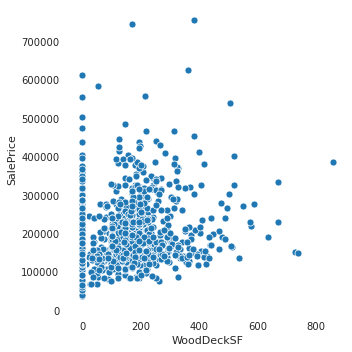

In [86]:
sns.relplot(x="WoodDeckSF",y='SalePrice',data=tot_tmp)

In [87]:
train_x = Utils.apply_log_trans(train_x, ['WoodDeckSF'])
test_x = Utils.apply_log_trans(test_x, ['WoodDeckSF'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


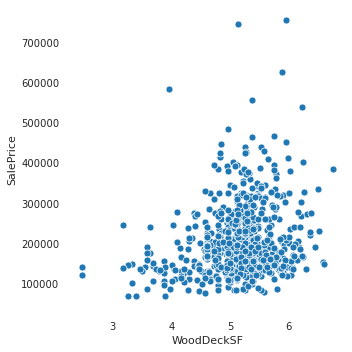

In [88]:
tot_tmp = pd.concat([train_x,train_y],axis=1,join='inner')
sns.relplot(x="WoodDeckSF",y='SalePrice',data=tot_tmp)

In [89]:
train_x[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal', 'MoSold', 'YrSold', 'TotalBsmtSF', 'GrLivArea', 'BsmtFinSF1',]]

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBsmtSF,GrLivArea,BsmtFinSF1
0,61,0,0,0,0,0,2,2008,6.752270,7.444249,6.559615
1,0,0,0,0,0,0,5,2007,7.140453,7.140453,6.885510
2,42,0,0,0,0,0,9,2008,6.824374,7.487734,6.186209
3,35,272,0,0,0,0,2,2006,6.628041,7.448334,5.375278
4,84,0,0,0,0,0,12,2008,7.043160,7.695303,6.484635
...,...,...,...,...,...,...,...,...,...,...,...
1455,40,0,0,0,0,0,8,2007,6.859615,7.406711,-inf
1456,0,0,0,0,0,0,2,2010,7.340836,7.636752,6.672033
1457,60,0,0,0,0,2500,5,2010,7.049255,7.757906,5.616771
1458,0,112,0,0,0,0,4,2010,6.982863,6.982863,3.891820


In [90]:
df = train_x.copy()
totdf = pd.DataFrame(df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['ScreenPorch'])
totdf.rename(columns={0:"Tot_porchSF"},inplace=True)
train_x = pd.concat([df,totdf],axis=1,join='inner')
train_x.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'],axis=1,inplace=True)
df = test_x.copy()
totdf = pd.DataFrame(df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['ScreenPorch'])
totdf.rename(columns={0:"Tot_porchSF"},inplace=True)
test_x = pd.concat([df,totdf],axis=1,join='inner')
test_x.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'],axis=1,inplace=True)

In [91]:
# sns.relplot(x="PoolArea",y="SalePrice",kind="line",data=tot_tmp)
test_x[test_x['PoolArea']==0]["PoolArea"].count()

1453

INFO: As more than 98% of PoolArea values are zero. We are droping it.

In [92]:
train_x.drop(['PoolArea'],axis=1,inplace=True)
test_x.drop(['PoolArea'],axis=1,inplace=True)

In [93]:
print(train_x[train_x['MiscVal']==0]["MiscVal"].count()/1460)
# sns.relplot(x="MiscVal",y="SalePrice",kind="line",data=tot_tmp)

0.963013698630137


INFO: 96% of MiscVal is 0. so ther will be no learning with this feature. Drop this feature.

In [94]:
train_x.drop(['MiscVal'],axis=1,inplace=True)
test_x.drop(['MiscVal'],axis=1,inplace=True)

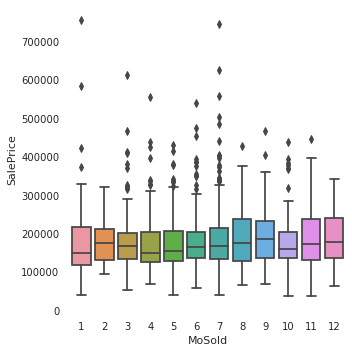

In [95]:
# lets check MoSold, YrSold correlation
sns.catplot(x="MoSold",y='SalePrice',data=tot_tmp,kind='box')

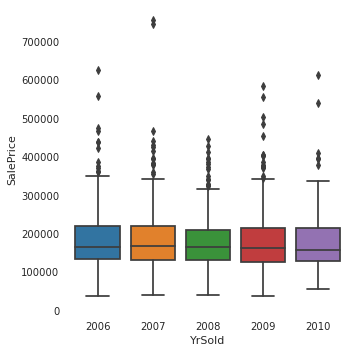

In [96]:
sns.catplot(x="YrSold",y='SalePrice',data=tot_tmp,kind='box')

In [97]:
train_x['GarageYrBlt'].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

## lets fill missing values.

First GarageyrBlt, as we know YearBlt and GarageYrBlt are highly correlated. we take missing values of GarageyrBlt from YearBlt.

In [98]:
test_x[test_x['GarageYrBlt'].isnull()]['GarageYrBlt']

53     NaN
71     NaN
79     NaN
92     NaN
96     NaN
        ..
1433   NaN
1449   NaN
1453   NaN
1454   NaN
1457   NaN
Name: GarageYrBlt, Length: 78, dtype: float64

In [99]:
test_data[test_data['GarageYrBlt'].isnull()]['GarageYrBlt']

53     NaN
71     NaN
79     NaN
92     NaN
96     NaN
        ..
1433   NaN
1449   NaN
1453   NaN
1454   NaN
1457   NaN
Name: GarageYrBlt, Length: 78, dtype: float64

In [100]:
val = Utils.missing_vals(train_x,"Id")
val.head(10)

,name,miss_val,miss_pct
246,LotFrontage,259,17.764060
8,GarageYrBlt,81,5.555556
248,MasVnrArea,8,0.548697
0,Id,0,0.000000
166,Exterior1st_HdBoard,0,0.000000
171,Exterior1st_Stucco,0,0.000000
170,Exterior1st_Stone,0,0.000000
169,Exterior1st_Plywood,0,0.000000
168,Exterior1st_MetalSd,0,0.000000
167,Exterior1st_ImStucc,0,0.000000


In [101]:
tmp = train_data[['Neighborhood','YearBuilt','GarageYrBlt']]
tmp2 = tmp[(tmp['YearBuilt'].notnull()) & (tmp['GarageYrBlt'].isnull())]
tmp2

,Neighborhood,YearBuilt,GarageYrBlt
39,Edwards,1955,NaN
48,OldTown,1920,NaN
78,Sawyer,1968,NaN
88,IDOTRR,1915,NaN
89,CollgCr,1994,NaN
...,...,...,...
1349,OldTown,1872,NaN
1407,Mitchel,1985,NaN
1449,MeadowV,1970,NaN
1450,NAmes,1974,NaN


In [102]:
for ind, row in tmp2.iterrows():
    train_x.at[ind,'GarageYrBlt'] = row['YearBuilt']

In [103]:
train_x[['Id','GarageYrBlt']].count()

Id             1458
GarageYrBlt    1458
dtype: int64

In [104]:
tmp = test_data[['Neighborhood','YearBuilt','GarageYrBlt']]
tmp3 = tmp[(tmp['YearBuilt'].notnull()) & (tmp['GarageYrBlt'].isnull())]
tmp3

,Neighborhood,YearBuilt,GarageYrBlt
53,NAmes,1962,NaN
71,OldTown,1920,NaN
79,OldTown,1910,NaN
92,OldTown,1912,NaN
96,SWISU,1915,NaN
...,...,...,...
1433,IDOTRR,1916,NaN
1449,MeadowV,1970,NaN
1453,MeadowV,1970,NaN
1454,MeadowV,1970,NaN


In [105]:
for ind, row in tmp3.iterrows():
    test_x.at[ind,'GarageYrBlt'] = row['YearBuilt']

In [106]:
test_x[test_x['GarageYrBlt'].isnull()]['GarageYrBlt']

Series([], Name: GarageYrBlt, dtype: float64)

LotFrontage is the avg value of the neighbourhood

In [107]:
tmp2 = pd.DataFrame(train_data.groupby('Neighborhood').agg({'LotFrontage':'mean'}))

In [108]:
tmp2['LotFrontage']['Blmngtn']

47.142857142857146

In [109]:
cptr = train_x
for ind, row in cptr.iterrows():
    if (math.isnan(cptr.at[ind,'LotFrontage'])):
        val = train_data.at[ind,'Id']
        val2 = pd.DataFrame(train_data.loc[train_data['Id']==val]['Neighborhood'])
        cptr.at[ind,'LotFrontage'] = tmp2['LotFrontage'][val2.iloc[0]['Neighborhood']]

In [110]:
train_x['LotFrontage'].count()

1458

In [111]:
cptr = test_x
tmp2 = pd.DataFrame(test_data.groupby('Neighborhood').agg({'LotFrontage':'mean'}))
for ind, row in cptr.iterrows():
    if (math.isnan(cptr.at[ind,'LotFrontage'])):
        val = test_data.at[ind,'Id']
        val2 = pd.DataFrame(test_data.loc[test_data['Id']==val]['Neighborhood'])
        cptr.at[ind,'LotFrontage'] = tmp2['LotFrontage'][val2.iloc[0]['Neighborhood']]

In [112]:
print (test_x['LotFrontage'].count())
print (test_x['Id'].count())

1459
1459


In [113]:
not_inf = train_x[train_x['MasVnrArea']!=np.NINF]
val = not_inf['MasVnrArea'].mean()
train_x.loc[train_x.MasVnrArea==np.NINF,'MasVnrArea'] = val
# train_x['MasVnrArea'].unique()

In [114]:
not_inf = train_x[train_x['MasVnrArea']!=np.NAN]
val = not_inf['MasVnrArea'].mean()
train_x.loc[train_x.MasVnrArea==np.NAN,'MasVnrArea'] = val

In [115]:
# all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
train_x['MasVnrArea'] = train_x['MasVnrArea'].fillna(val)

In [116]:
# use mean of train to fill test data too.
test_x['MasVnrArea'] = test_x['MasVnrArea'].fillna(val)

In [117]:
test_x.loc[test_x.MasVnrArea==np.NINF,'MasVnrArea'] = val

In [118]:
val = Utils.missing_vals(test_x,"Id")
val.head(10)

,name,miss_val,miss_pct
234,TotalBath,2,0.13708
16,BsmtUnfSF,1,0.06854
15,BsmtFinSF2,1,0.06854
14,BsmtFinSF1,1,0.06854
9,GarageCars,1,0.06854
12,TotalBsmtSF,1,0.06854
0,Id,0,0.00000
159,Exterior1st_MetalSd,0,0.00000
162,Exterior1st_VinylSd,0,0.00000
161,Exterior1st_Stucco,0,0.00000


In [119]:
test_x = test_x.replace({np.NINF:0})
train_x = train_x.replace({np.NINF:0})


In [120]:
test_x['BsmtUnfSF'].mean()

5.602777467347591

In [121]:
test_x['GarageCars'] = test_x['GarageCars'].fillna(test_x['GarageCars'].mode()[0])
test_x['BsmtUnfSF'] = test_x['BsmtUnfSF'].fillna(test_x['BsmtUnfSF'].mean())
test_x['BsmtFinSF2'] = test_x['BsmtFinSF2'].fillna(test_x['BsmtFinSF2'].mean())
test_x['BsmtFinSF1'] = test_x['BsmtFinSF1'].fillna(test_x['BsmtFinSF1'].mean())
test_x['TotalBsmtSF'] = test_x['TotalBsmtSF'].fillna(test_x['TotalBsmtSF'].mean())
test_x['TotalBath'] = test_x['TotalBath'].fillna(test_x['TotalBath'].mean())

In [122]:
val = Utils.missing_vals(test_x,"Id")
val.head(10)

,name,miss_val,miss_pct
0,Id,0,0.0
163,Exterior1st_Wd Sdng,0,0.0
151,HouseStyle_SLvl,0,0.0
152,Exterior1st_AsbShng,0,0.0
153,Exterior1st_AsphShn,0,0.0
154,Exterior1st_BrkComm,0,0.0
155,Exterior1st_BrkFace,0,0.0
156,Exterior1st_CBlock,0,0.0
157,Exterior1st_CemntBd,0,0.0
158,Exterior1st_HdBoard,0,0.0


In [123]:
print (train_x.shape)
print (test_x.shape)

(1458, 253)
(1459, 237)


In [124]:
tr_cols = train_x.columns
ts_cols = test_x.columns
diff = [col for col in tr_cols if col not in ts_cols]
diff

['Electrical_Mix',
 'Utilities_NoSeWa',
 'RoofMatl_ClyTile',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Exterior2nd_Other',
 'HouseStyle_2.5Fin',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'GarageQual_5',
 'Heating_Floor',
 'Heating_OthW']

above all the _xxx values are categorical values which are not there in test but they are in train. So we can't do anything about it.

In [125]:
# we still need to figure out what should we do with month and year

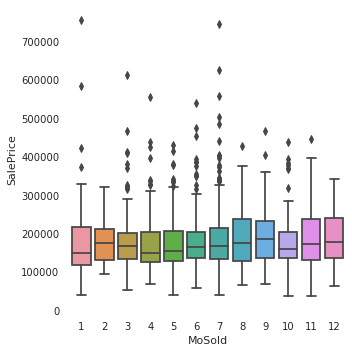

In [126]:
tmp=pd.concat([train_x,train_y],join="inner",axis=1)
sns.catplot(x="MoSold",y="SalePrice",data=tmp,kind="box")

there is not much difference in saleprice w.r.t MoSold. so lets drop it.

In [127]:
train_x.drop(['MoSold'],axis=1,inplace=True)
test_x.drop(['MoSold'],axis=1,inplace=True)

In [128]:
# lets see correlation between age of a age house sold and saleprice.
age = pd.DataFrame(train_x['YrSold'] - train_x['GarageYrBlt'])
age.rename({0:"agelog"},inplace=True,axis=1)
age = Utils.apply_log_trans(age,['agelog'])
train_x = pd.concat([train_x,age],axis=1,join='inner')
train_x.drop(['YrSold','GarageYrBlt'],axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [129]:
age = pd.DataFrame(test_x['YrSold'] - test_x['GarageYrBlt'])
age.rename({0:"agelog"},inplace=True,axis=1)
age = Utils.apply_log_trans(age,['agelog'])
test_x = pd.concat([test_x,age],axis=1,join='inner')
test_x.drop(['YrSold','GarageYrBlt'],axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [130]:
test_x = test_x.replace({np.NINF:0})
train_x = train_x.replace({np.NINF:0})

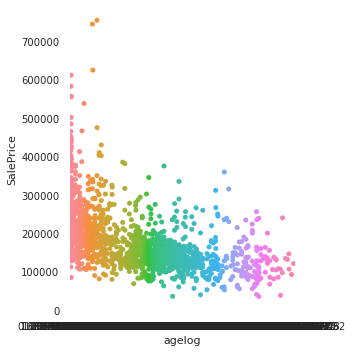

In [131]:
tmp=pd.concat([train_x,train_y],join="inner",axis=1)
sns.catplot(x="agelog",y="SalePrice",data=tmp)

In [132]:
train_x.describe()

,Id,OverallQual,OverallCond,YearRemodAdd,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,TotalBsmtSF,...,Heating_OthW,Heating_Wall,LotFrontage,LotArea,MasVnrArea,2ndFlrSF,TotalBath,WoodDeckSF,Tot_porchSF,agelog
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,...,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.969822,6.096022,5.574760,1984.834705,5.852538,2.865569,1.046639,0.611111,1.766804,6.748443,...,0.001372,0.002743,16.564317,9.108732,5.225340,2.863195,2.428669,2.453414,87.004115,2.812550
std,421.601941,1.379962,1.112835,20.642513,48.655960,0.815789,0.220483,0.641988,0.747778,1.145267,...,0.037024,0.052324,26.934047,0.514431,0.555960,3.292380,0.920700,2.593313,105.100762,1.397950
min,1.000000,1.000000,1.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.044522,7.170120,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,365.250000,5.000000,5.000000,1967.000000,0.000000,2.000000,1.000000,0.000000,1.000000,6.679599,...,0.000000,0.000000,4.094345,8.928574,5.225340,0.000000,2.000000,0.000000,0.000000,1.945910
50%,729.500000,6.000000,5.000000,1994.000000,0.000000,3.000000,1.000000,1.000000,2.000000,6.899219,...,0.000000,0.000000,4.304065,9.156412,5.225340,0.000000,2.000000,0.000000,48.000000,3.401197
75%,1094.750000,7.000000,6.000000,2004.000000,0.000000,3.000000,1.000000,1.000000,2.000000,7.168387,...,0.000000,0.000000,4.584967,9.358760,5.225340,6.590301,3.000000,5.123964,136.000000,3.891820
max,1460.000000,10.000000,9.000000,2010.000000,572.000000,8.000000,3.000000,3.000000,4.000000,8.072779,...,1.000000,1.000000,91.878788,12.279532,7.377759,7.632886,6.000000,6.753438,1027.000000,4.912655


In [133]:
# for col in train_x.columns():
#     print (train_x)
a = train_x.max()
cols = train_x.columns
for i,col in zip(a,cols) :
    print (col,i)

Id 1460.0
OverallQual 10.0
OverallCond 9.0
YearRemodAdd 2010.0
LowQualFinSF 572.0
BedroomAbvGr 8.0
KitchenAbvGr 3.0
Fireplaces 3.0
GarageCars 4.0
TotalBsmtSF 8.072779333169498
GrLivArea 8.450198322591959
BsmtFinSF1 7.723120092266331
BsmtFinSF2 7.295735072749282
BsmtUnfSF 7.756195343948118
LotShape_IR1 1.0
LotShape_IR2 1.0
LotShape_IR3 1.0
LotShape_Reg 1.0
LotConfig_Corner 1.0
LotConfig_CulDSac 1.0
LotConfig_FR2 1.0
LotConfig_FR3 1.0
LotConfig_Inside 1.0
Condition1_Artery 1.0
Condition1_Feedr 1.0
Condition1_Norm 1.0
Condition1_PosA 1.0
Condition1_PosN 1.0
Condition1_RRAe 1.0
Condition1_RRAn 1.0
Condition1_RRNe 1.0
Condition1_RRNn 1.0
CentralAir_N 1.0
CentralAir_Y 1.0
ExterQual_Ex 1.0
ExterQual_Fa 1.0
ExterQual_Gd 1.0
ExterQual_TA 1.0
Foundation_BrkTil 1.0
Foundation_CBlock 1.0
Foundation_PConc 1.0
Foundation_Slab 1.0
Foundation_Stone 1.0
Foundation_Wood 1.0
Electrical_FuseA 1.0
Electrical_FuseF 1.0
Electrical_FuseP 1.0
Electrical_Mix 1.0
Electrical_SBrkr 1.0
GarageFinish_3 1.0
GarageFin

In [134]:
train_x[['Tot_porchSF','YearRemodAdd','LowQualFinSF']]

,Tot_porchSF,YearRemodAdd,LowQualFinSF
0,61,2003,0
1,0,1976,0
2,42,2002,0
3,307,1970,0
4,84,2000,0
...,...,...,...
1455,40,2000,0
1456,0,1988,0
1457,60,2006,0
1458,112,1996,0


In [135]:
train_x[train_x['LowQualFinSF']==0]['LowQualFinSF']

0       0
1       0
2       0
3       0
4       0
       ..
1455    0
1456    0
1457    0
1458    0
1459    0
Name: LowQualFinSF, Length: 1432, dtype: int64

In [136]:
train_x.drop('LowQualFinSF',axis=1,inplace=True)
test_x.drop('LowQualFinSF',axis=1,inplace=True)

In [137]:
train_x.drop('YearRemodAdd',axis=1,inplace=True)
test_x.drop('YearRemodAdd',axis=1,inplace=True)

In [138]:
train_x = Utils.apply_log_trans(train_x, ['Tot_porchSF'])
test_x = Utils.apply_log_trans(test_x, ['Tot_porchSF'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [139]:
test_x = test_x.replace({np.NINF:0})
train_x = train_x.replace({np.NINF:0})

In [140]:
train_x.drop('Id',axis=1,inplace=True)
test_x.drop('Id',axis=1,inplace=True)

In [141]:
print (train_x.shape)
print (train_y.shape)
print (test_x.shape)

(1458, 248)
(1460, 1)
(1459, 232)


In [142]:
# so drop those 2 rows from train_y
tx_rows = train_x.index
ty_rows = train_y.index
for row in ty_rows:
    if row not in tx_rows:
        print (row)


934
1298


In [143]:
train_y.drop([934,1298],inplace=True)
print (train_x.shape)
print (train_y.shape)
print (test_x.shape)

(1458, 248)
(1458, 1)
(1459, 232)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [144]:
types = train_x.dtypes.unique()
print (types)

[dtype('int64') dtype('float64') dtype('uint8')]


In [145]:
num_features = train_x.dtypes[train_x.dtypes != "uint8"].index
for val in num_features:
    print(val)

OverallQual
OverallCond
BedroomAbvGr
KitchenAbvGr
Fireplaces
GarageCars
TotalBsmtSF
GrLivArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
LotFrontage
LotArea
MasVnrArea
2ndFlrSF
TotalBath
WoodDeckSF
agelog
Tot_porchSF


apply box cox transformation to highly skewed coumns (skewness >0.75)

In [146]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
skewness = Utils.cal_skewness(train_x)
skewness


Skew in numerical features: 



,Skew
RoofMatl_Membran,38.144471
Exterior2nd_CBlock,38.144471
Exterior1st_CBlock,38.144471
Functional_Sev,38.144471
RoofMatl_Metal,38.144471
...,...
Heating_GasA,-6.525714
RoofMatl_CompShg,-7.600443
Condition2_Norm,-9.706204
Street_Pave,-15.492067


In [147]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0])+" But we are only transforming following columns")
print (num_features)
# but we apply transformation to numerical features only, because they are ordinal values.(above listed features)
# cptr = train_x.copy()
# from scipy.special import boxcox1p
# lam = 0.05
# for feat in num_features:
#     train_x[feat] = boxcox1p(train_x[feat], lam)
#     test_x[feat] = boxcox1p(test_x[feat], lam)
# ylam = 0.001
# train_y = boxcox1p(train_y,ylam)

There are 248 skewed numerical features to Box Cox transform But we are only transforming following columns
Index(['OverallQual', 'OverallCond', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'GarageCars', 'TotalBsmtSF', 'GrLivArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'LotFrontage', 'LotArea', 'MasVnrArea',
       '2ndFlrSF', 'TotalBath', 'WoodDeckSF', 'agelog', 'Tot_porchSF'],
      dtype='object')


In [148]:
# boxcox coudn't transform saleprice to 0-3 range instead its capping at 10-15
# so we are using standard scalar to all numerical and target features.
from sklearn.preprocessing import StandardScaler
xscal = StandardScaler()
train_x[num_features] = xscal.fit_transform(train_x[num_features])
test_x[num_features] = xscal.transform(test_x[num_features])

yscal = StandardScaler()
train_y = pd.DataFrame(yscal.fit_transform(train_y))


In [149]:
print (train_x.shape)
print (train_y.shape)
print (test_x.shape)

(1458, 248)
(1458, 1)
(1459, 232)


In [150]:
tr_cols = train_x.columns
ts_cols = test_x.columns
diff = list (set(tr_cols) - set(ts_cols))
for col in diff:
    train_x.drop (col, inplace=True,axis=1)

In [151]:
print (train_x.shape)
print (train_y.shape)
print (test_x.shape)

(1458, 232)
(1458, 1)
(1459, 232)


In [152]:
# from scipy import stats
# from scipy.stats import norm, skew #for some statistics
skewness = Utils.cal_skewness(train_x)
skewness


Skew in numerical features: 



,Skew
Exterior1st_CBlock,38.144471
Exterior2nd_CBlock,38.144471
Functional_Sev,38.144471
Exterior1st_AsphShn,38.144471
Condition2_PosA,38.144471
...,...
Heating_GasA,-6.525714
RoofMatl_CompShg,-7.600443
Condition2_Norm,-9.706204
Street_Pave,-15.492067


In [153]:
train_x[['OverallQual', 'OverallCond', 'BedroomAbvGr', 'KitchenAbvGr','Fireplaces', 'GarageCars', 'TotalBsmtSF', 'GrLivArea', 'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'LotFrontage', 'LotArea', 'MasVnrArea','2ndFlrSF', 'TotalBath', 'WoodDeckSF', 'agelog', 'Tot_porchSF']]

,OverallQual,OverallCond,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,TotalBsmtSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LotFrontage,LotArea,MasVnrArea,2ndFlrSF,TotalBath,WoodDeckSF,agelog,Tot_porchSF
0,0.655299,-0.516660,0.164843,-0.211605,-0.952231,0.311959,0.003343,0.535803,0.781506,-0.355564,-0.342146,-0.460168,-0.129917,0.094958,1.180930,1.707255,-0.946378,-0.860921,0.457336
1,-0.069607,2.180083,0.164843,-0.211605,0.605965,0.311959,0.342404,-0.380381,0.890486,-0.355564,0.001923,-0.452456,0.118202,0.000000,-0.869941,0.620752,1.251215,0.444687,-1.405806
2,0.655299,-0.516660,0.164843,-0.211605,0.605965,0.311959,0.066322,0.666945,0.656639,-0.355564,0.230499,-0.458492,0.426620,-0.247844,1.185170,1.707255,-0.946378,-0.620149,0.288192
3,0.655299,-0.516660,0.164843,-0.211605,0.605965,1.649713,-0.105166,0.548123,0.385463,-0.355564,0.348286,-0.463141,0.108048,0.000000,1.143895,-0.465751,-0.946378,-0.524597,1.189733
4,1.380206,-0.516660,1.391070,-0.211605,0.605965,1.649713,0.257423,1.292930,0.756433,-0.355564,0.295914,-0.450644,0.887656,1.138230,1.244574,1.707255,1.081645,-0.524597,0.602342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.069607,-0.516660,0.164843,-0.211605,0.605965,0.311959,0.097104,0.422596,-1.412037,-0.355564,0.654466,-0.461923,-0.256613,0.000000,1.117896,0.620752,-0.946378,-0.524597,0.266079
1456,-0.069607,0.382254,0.164843,-0.211605,2.164162,0.311959,0.517430,1.116353,0.819099,2.406395,0.395102,-0.450204,0.733769,-0.802882,-0.869941,0.620752,1.312154,0.467406,-1.405806
1457,0.655299,3.078997,1.391070,-0.211605,2.164162,-1.025795,0.262746,1.481728,0.466218,-0.355564,0.609670,-0.459601,0.001757,0.000000,1.271875,-0.465751,-0.946378,1.017236,0.449845
1458,-0.794513,0.382254,-1.061384,-0.211605,-0.952231,-1.025795,0.204756,-0.855640,-0.110607,3.405496,-3.042912,-0.458492,0.141759,0.000000,-0.869941,-0.465751,1.330500,0.917225,0.732726


In [154]:
train_y

,0
0,0.347461
1,0.007632
2,0.536254
3,-0.514698
4,0.869790
...,...
1453,-0.074179
1454,0.366340
1455,1.077463
1456,-0.487952


## cv and submission results

### after log,boxcox trans to num features and target.
Xgboost score: 0.0233 (0.0014) <br>
LGBM score: 0.0136 (0.0014) <br>
Lasso score: 0.0152 (0.0014) <br>

### scalar trans to num features and target

But back transformation of (log(boxcox(target))) is very difficult and boxcox(target) is not sufficient. <br> So, we did scalar transformation but it is giving more rmse.<br>
Xgboost score: 0.3266 (0.0858)<br>
LGBM score: 0.3334 (0.0789)<br>
Lasso score: 0.3615 (0.0577) <br>
Submission accuracy of this method is 0.1253 (rank: 1312;75% percentile) <br>

### boxcox 
(scipy.special.inv_boxcox(y, 2.5))

# Model learning

We use different models and check rms error value.

In [155]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_x.values)
    rmse= np.sqrt(-cross_val_score(model, train_x.values, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [156]:
# this is a basic modelling technique.
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb



model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Xgboost score: 0.3266 (0.0858)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

LGBM score: 0.3334 (0.0789)



In [157]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14601772022450632, tolerance: 0.12020368398328349
  positive)



Lasso score: 0.3615 (0.0577)



In [158]:
# lets get test results 
model = model_lgb.fit(train_x,train_y)
y_test_pred = model.predict(test_x)
y_test_pred

array([-0.7126417 , -0.27712067,  0.09429287, ..., -0.4336429 ,
       -0.72301508,  0.4907021 ])

In [159]:
# lets inverse transform y_test_prid
y_test_pred = yscal.inverse_transform(y_test_pred)

In [160]:
y_test_pred = pd.DataFrame(y_test_pred)

In [161]:
y_test_pred.rename({0:"SalePrice"},axis=1,inplace=True)

In [162]:
y_test_pred

,SalePrice
0,124273.024875
1,158875.931272
2,188385.386450
3,194382.693191
4,190426.413778
...,...
1454,86793.658944
1455,80512.958712
1456,146439.966880
1457,123448.841100


In [163]:
yid = pd.DataFrame(test_data['Id'])
yid

,Id
0,1461
1,1462
2,1463
3,1464
4,1465
...,...
1454,2915
1455,2916
1456,2917
1457,2918


In [164]:
result = pd.concat([yid,y_test_pred],axis=1,join='inner')
result

,Id,SalePrice
0,1461,124273.024875
1,1462,158875.931272
2,1463,188385.386450
3,1464,194382.693191
4,1465,190426.413778
...,...,...
1454,2915,86793.658944
1455,2916,80512.958712
1456,2917,146439.966880
1457,2918,123448.841100


In [165]:
result.to_csv("with_scalar_trans_all.csv",index=False)

In [166]:
# following are existing methods to do some stuff. I did these in a traditional way.
# indexes = df1.loc[df1.Code.isin(df2.Code.values)].index
# df1.at[indexes,'Value'] = df2['Value'].values

# all_df["SimplOverallQual"] = all_df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})

# qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
# all_df["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)

